# Working with uDALES field data in Python

This tutorial demonstrates how to read and process field data output of the LES code uDALES using Python. In addition, it describes some important concepts, such as the grid layout, variable locations and averaging procedures.

The `udbase` post-processing class reads in most important input parameters, and contains a number of methods to load field data:

- **load_stat_xyt**: Load statistics averaged in the vertical (z-direction) but varying with x-y-t from `xytdump.expnr.nc`
- **load_stat_t**: Load statistics averaged in the horizontal (x-y plane) but varying with z-t from `tdump.expnr.nc`
- **load_field**: Load instantaneous 3D data from `fielddump.expnr.nc`
- **load_slice**: Load instantaneous 2D slices from `Xslicedump.expnr.nc`
- **load_stat_tree**: Load tree source terms from `treedump.expnr.nc` (for simulations with trees)
- **plot_trees**: Plot tree patches

## Initialising udbase

The starting point of this tutorial is that you have run a simulation and have merged the output files. If the simulations were performed on a HPC system, we assume that you have copied the output directory to your own workstation.

Note that the `uDALES/tools/python` path must be accessible to import the udbase class.

In [22]:
# preamble
import sys

sys.path.append('../../tools/python')

from udbase import UDBase
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# create an instance of the udbase class
expnr = 110
expdir = 'C:/Users/mvr/OneDrive - Imperial College London/projects/2024_uDALES_sprint/udales-pp/experiments/110'
udales = UDBase(expnr, expdir)

Loaded geometry: 1102 faces, 624 vertices


c:\Users\mvr\OneDrive - Imperial College London\codes\uDALES\u-dales\docs\tutorial_mlx\../../tools/python\udbase.py:153: UserWarning: prof.inp.110 not found. Assuming equidistant grid.
  warnings.warn(f"prof.inp.{self.expnr} not found. Assuming equidistant grid.")


## uDALES grid layout

uDALES uses a grid that is staggered, which means that not all variables are defined at the same location on the grid. Staggering is computationally advantageous, but requires care with plotting, as it is important to plot variables in their correct location. uDALES' grid layout is as follows.

In [18]:
# 2D view of staggered grid arrangement
# (x-z direction; grid layout in other directions is identical)
#
#                           w(i,j,k+1)
#                               ^
# zm(k+1) --            --------|--------
#                       |               |
#                       |   c(i,j,k)    |
#   zt(k) --  u(i,j,k) --->     o      ---> u(i+1,j,k)
#                       |               |
#                       |       ^       |
#   zm(k) --            --------|--------
#                           w(i,j,k)
#
#                       |       |       |
#                     xm(i)   xt(i)   xm(i+1)
#
#   Coordinate positions (assuming z-grid is equidistant)
#   xm(i) = (i-1) * dx;     xt(i) = (i-1/2) * dx
#   ym(j) = (j-1) * dy;     yt(j) = (j-1/2) * dy
#   zm(k) = (k-1) * dz;     zt(k) = (k-1/2) * dz
#
#   Grid increments:
#   dzt(k) = zm(k+1) - zm(k)
#   dzm(k) = zt(k) - zt(k-1)
#
#   Note that z does not have to be equidistant.

There are six arrays for the coordinates:

- **xm**: x-coordinate of cell edges
- **xt**: x-coordinate of cell centres
- **ym**: y-coordinate of cell edges
- **yt**: y-coordinate of cell centres
- **zm**: z-coordinate of cell edges
- **zt**: z-coordinate of cell centres

The field variables are defined as follows:

- **u(i,j,k)** is the u-velocity at location (xm(i), yt(j), zt(k))
- **v(i,j,k)** is the v-velocity at location (xt(i), ym(j), zt(k))
- **w(i,j,k)** is the w-velocity at location (xt(i), yt(j), zm(k))
- **c(i,j,k)** is a scalar quantity at location (xt(i), yt(j), zt(k))

Scalars (potential temperature, specific humidity, pollutants) are always defined in the cell-centre. Fluxes are typically defined on the cell edges.

You can always look up where the variables are defined from the output variable information using the load methods.

## Averages used in uDALES output

Many of the outputs of uDALES have been averaged in some manner. This is advantageous as these are often the quantities we are interested in, and also require much less diskspace and memory to process.

The Reynolds decomposition is used to decompose variables into mean quantities and their fluctuations:

$$\varphi(x,y,z,t) = \overline{\varphi}(x,y,z) + \varphi'(x,y,z,t)$$

where the overbar denotes time-averaging. The time-averaged data is contained in the `tdump.expnr.nc` file.

Often, we are interested in the quantities that are additionally averaged in the horizontal plane. This is often referred to as a slab average. In this case it is common to further decompose the time-averaged quantity $\overline{\varphi}$ into a spatial average $\langle\overline{\varphi}\rangle(z)$ (i.e., average over the horizontal surface) and its spatial variation $\overline{\varphi}''(x,y,z) = \overline{\varphi}(x,y,z) - \langle\overline{\varphi}\rangle(z)$. Upon substituting this expression into the equation above, we obtain the triple decomposition:

$$\varphi(x,y,z,t) = \langle\overline{\varphi}\rangle(z) + \overline{\varphi}''(x,y,z) + \varphi'(x,y,z,t)$$

Here, $\langle\overline{\varphi}\rangle$ is an intrinsic average, defined as:

$$\langle\overline{\varphi}\rangle(z) = \frac{1}{A_f} \int_{\Omega_f} \varphi \, dA$$

where $A_f(z)$ is the area occupied by fluid and $\Omega_f$ is the horizontal surface that is occupied by the fluid. The quantity $\langle\overline{\varphi}\rangle$ represents the average value of $\overline{\varphi}$ inside the fluid between the buildings. Another commonly used quantity is the comprehensive average $\langle\overline{\varphi}\rangle_C$, which is defined as:

$$\langle\overline{\varphi}\rangle_C(z) = \frac{1}{A} \int_{\Omega_f} \varphi \, dA = \frac{A_f}{A} \langle\overline{\varphi}\rangle(z)$$

where $A$ is the total surface area. In many cases, it is more convenient to work with comprehensive averages than intrinsic averages, particularly when considering averaged budgets of momentum, temperature etc. To convert the intrinsic-average output from uDALES into a comprehensive average, simply multiply the intrinsic average by $A_f/A$ as shown above. Time and intrinsically-averaged data is contained in the `xytdump.expnr.nc` file.

## load_stat_xyt: loading time- and slab-averaged data

The method **load_stat_xyt** loads statistics averaged in the vertical (z-direction) but varying with x-y-t into an xarray Dataset. First let's call it to see what variables are available:

In [19]:
# View contents of xytdump file
# udales.load_stat_xyt()  # Uncomment to see available variables

# Load all xyt statistics
ds_xyt = udales.load_stat_xyt()
print(ds_xyt)


Contents of xytdump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
pxyt                 time, zt                       3 x 256             
qtxyt                time, zt                       3 x 256             
thlpthlptxy          time, zt                       3 x 256             
thlsgsxyt            time, zm                       3 x 256             
thlxyt               time, zt                       3 x 256             
tketxyc              time, zt                       3 x 256             
upuptxyc             time, zt                       3 x 256             
upvpxyt              time, zm                       3 x 256             
upwpxyt              time, zm                       3 x 256             
usgsxyt              time, zm                       3 x 256             
uvxyt                time, zm                       3 x 256             
uwxyt                tim

Before showing how to display the data, let's examine the time coordinate. The entire runtime is divided into time intervals in each of which the time average is taken. These can be understood by considering the input parameters `tstatsdump` and `runtime`:

In [20]:
# Check time coordinate and averaging intervals
txyt = ds_xyt['time']
print(f"Time values: {txyt.values}")
print(f"tstatsdump = {udales.tstatsdump if hasattr(udales, 'tstatsdump') else 'not available'}")
print(f"runtime = {udales.runtime if hasattr(udales, 'runtime') else 'not available'}")

Time values: [2000.1102 4000.0815 6000.117 ]
tstatsdump = 2000
runtime = 6002.0


In [25]:
# Test the transpose by checking the dataset structure
import importlib
import udbase
importlib.reload(udbase)
from udbase import UDBase

# Recreate udales instance with reloaded module
udales_new = UDBase(110, expdir)

# Load dataset
ds_test = udales_new.load_stat_xyt()

print("Dataset variables (first 3):")
for i, (name, var) in enumerate(ds_test.data_vars.items()):
    if i >= 3:
        break
    print(f"  {name}: dims={var.dims}, shape={var.shape}")

# Extract uxyt
uxyt_new = ds_test['uxyt']
print(f"\nuxyt from dataset: dims={uxyt_new.dims}, shape={uxyt_new.shape}")
print(f"Expected MATLAB: dims=(zt, time), shape=(256, 3)")

Loaded geometry: 1102 faces, 624 vertices

Contents of xytdump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
pxyt                 zt, time                       256 x 3             
qtxyt                zt, time                       256 x 3             
thlpthlptxy          zt, time                       256 x 3             
thlsgsxyt            zm, time                       256 x 3             
thlxyt               zt, time                       256 x 3             
tketxyc              zt, time                       256 x 3             
upuptxyc             zt, time                       256 x 3             
upvpxyt              zm, time                       256 x 3             
upwpxyt              zm, time                       256 x 3             
usgsxyt              zm, time                       256 x 3             
uvxyt                zm, time                       256

c:\Users\mvr\OneDrive - Imperial College London\codes\uDALES\u-dales\docs\tutorial_mlx\../../tools/python\udbase.py:153: UserWarning: prof.inp.110 not found. Assuming equidistant grid.
  warnings.warn(f"prof.inp.{self.expnr} not found. Assuming equidistant grid.")


In [26]:
# Test 3D field data (tdump) - should be (xm, yt, zt, time)
ds_t_test = udales_new.load_stat_t()
print("\n3D field data (tdump):")
print("Dataset variables (first 3):")
for i, (name, var) in enumerate(ds_t_test.data_vars.items()):
    if i >= 3:
        break
    print(f"  {name}: dims={var.dims}, shape={var.shape}")

# In NetCDF: (time, zt, yt, xm) -> After transpose: (xm, yt, zt, time)
print("\nExpected MATLAB shape for 'ut': (128, 128, 256, 3) = (xm, yt, zt, time)")

True

Contents of tdump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
PSS                  xt, yt, zt, time               128 x 128 x 256 x 3 
pt                   xt, yt, zt, time               128 x 128 x 256 x 3 
qtt                  xt, yt, zt, time               128 x 128 x 256 x 3 
sca1psca1pt          xt, yt, zt, time               128 x 128 x 256 x 3 
sca1t                xt, yt, zt, time               128 x 128 x 256 x 3 
sca2psca2pt          xt, yt, zt, time               128 x 128 x 256 x 3 
sca2t                xt, yt, zt, time               128 x 128 x 256 x 3 
sca3psca3pt          xt, yt, zt, time               128 x 128 x 256 x 3 
sca3t                xt, yt, zt, time               128 x 128 x 256 x 3 
sca4psca4pt          xt, yt, zt, time               128 x 128 x 256 x 3 
sca4t                xt, yt, zt, time               128 x 128 x 256 x 3 
sv1sgs               

The vertical coordinate z and mean streamwise velocity $\langle\overline{u}\rangle$ can be plotted for each averaging time interval:

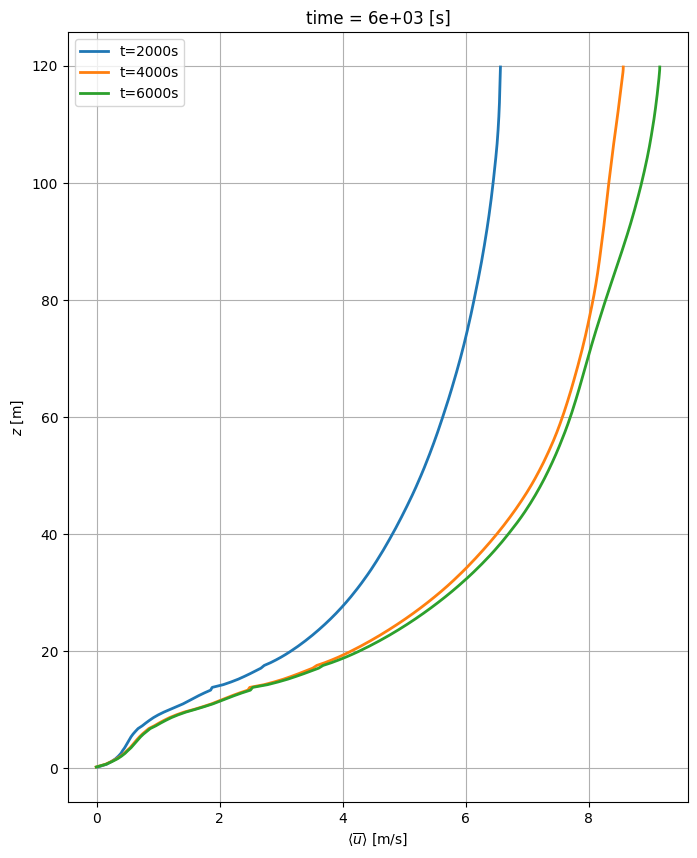

In [7]:
zt = ds_xyt['zt'] if 'zt' in ds_xyt.coords else ds_xyt['z']
uxyt = ds_xyt['uxyt'] if 'uxyt' in ds_xyt else ds_xyt['u']

fig, ax = plt.subplots(figsize=(8, 10))
for n, t in enumerate(txyt):
    uxyt.sel(time=t).plot(y='zt', ax=ax, label=f't={float(t):.0f}s', linewidth=2)
ax.set_xlabel('$\\langle \\overline{u} \\rangle$ [m/s]')
ax.set_ylabel('$z$ [m]')
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

As can be seen, during the first time-interval, the flow may be substantially different than in later intervals, suggesting an initial transient. Although profiles for later time-intervals may be close, they might not be identical showing that either the flow has not equilibriated entirely, or the chosen averaging time-interval was too small, or both.

Using the continuity equation it can be shown that for periodic domains $\langle\overline{w}\rangle = 0$, which also implies that $\langle\overline{w}''\rangle = 0$. This means that the dispersive momentum flux $\langle\overline{u}''\overline{w}''\rangle$ is equal to $\langle\overline{u}\overline{w}\rangle$. Thus, we can load the mean turbulent horizontal momentum flux $\langle\overline{u'w'}\rangle$ and dispersive flux $\langle\overline{u}''\overline{w}''\rangle$:

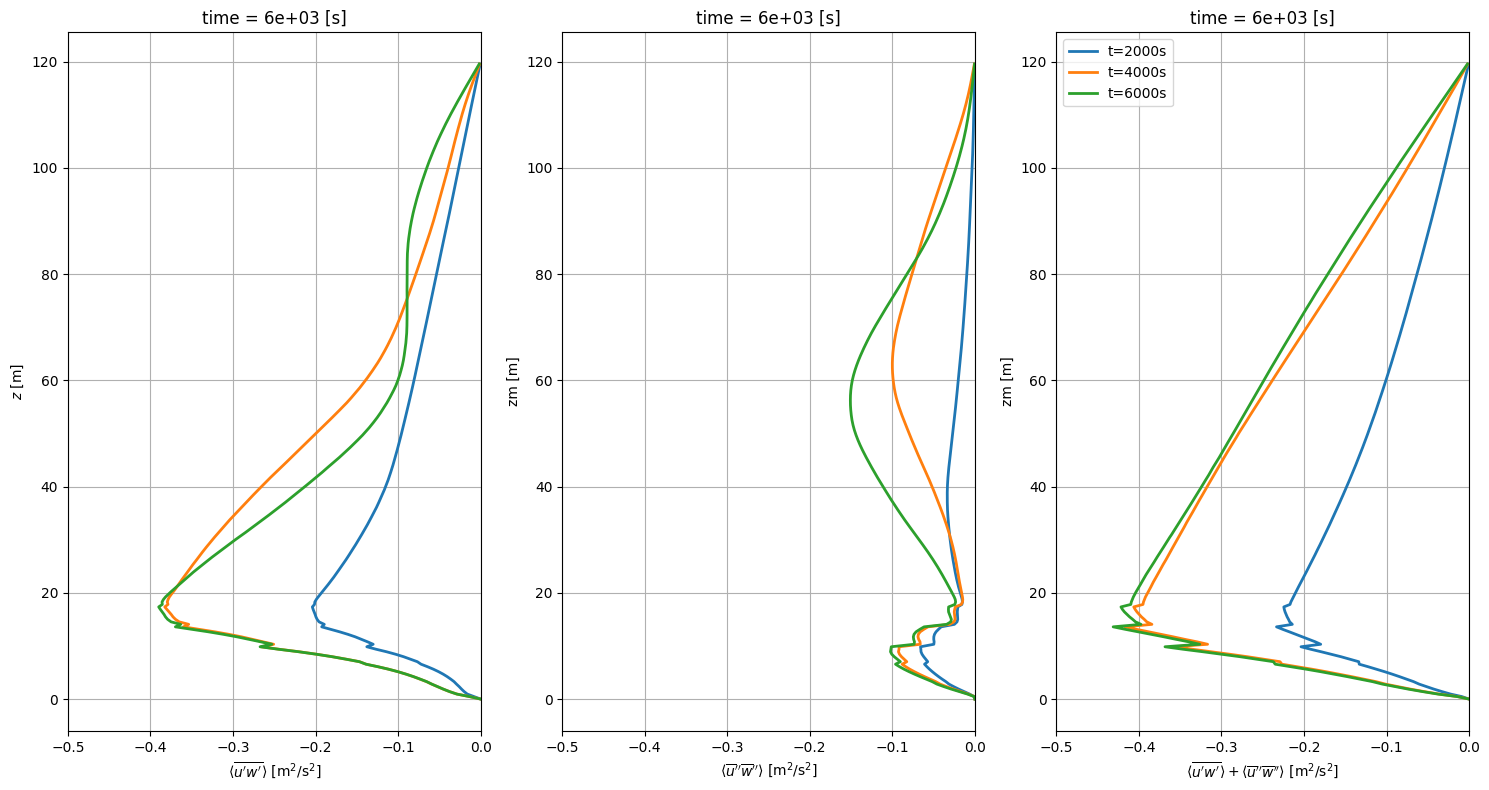

In [8]:
# Try to load turbulent and dispersive fluxes
try:
    # Check if flux variables are in the dataset
    zm = ds_xyt['zm'] if 'zm' in ds_xyt.coords else ds_xyt['z']
    
    if 'upwpxyt' in ds_xyt and 'uwxyt' in ds_xyt:
        upwpxyt = ds_xyt['upwpxyt']
        uwxyt = ds_xyt['uwxyt']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 8))
        
        # Turbulent flux
        for n, t in enumerate(upwpxyt['time']):
            upwpxyt.sel(time=t).plot(y='zm', ax=axes[0], label=f't={float(t):.0f}s', linewidth=2)
        axes[0].set_xlabel("$\\langle \\overline{u'w'} \\rangle$ [m$^2$/s$^2$]")
        axes[0].set_ylabel('$z$ [m]')
        axes[0].set_xlim([-0.5, 0])
        axes[0].grid(True)
        
        # Dispersive flux  
        for n, t in enumerate(uwxyt['time']):
            uwxyt.sel(time=t).plot(y='zm', ax=axes[1], label=f't={float(t):.0f}s', linewidth=2)
        axes[1].set_xlabel("$\\langle \\overline{u}'' \\overline{w}'' \\rangle$ [m$^2$/s$^2$]")
        axes[1].set_xlim([-0.5, 0])
        axes[1].grid(True)
        
        # Total flux
        for n, t in enumerate(uwxyt['time']):
            (upwpxyt + uwxyt).sel(time=t).plot(y='zm', ax=axes[2], label=f't={float(t):.0f}s', linewidth=2)
        axes[2].set_xlabel("$\\langle \\overline{u'w'} \\rangle + \\langle \\overline{u}'' \\overline{w}'' \\rangle$ [m$^2$/s$^2$]")
        axes[2].set_xlim([-0.5, 0])
        axes[2].legend(loc='upper left')
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Flux variables (upwpxyt, uwxyt) not available in dataset")
except Exception as e:
    print(f"Error loading flux data: {e}")

To interpret this data, it is easiest to start with the right-most figure which plots the sum of the dispersive and turbulent fluxes. In a steady state (and for a simulation with a constant pressure gradient or average velocity), we expect this quantity to form a straight line, which is the case for the last time-intervals. The data are also nearly collapsing for the last time-intervals, once more suggesting that these flows are close to a statistical steady state.

The turbulent and dispersive fluxes show substantial variation for all curves, showing that much longer averaging is needed to obtain reliable statistics for these quantities.

## load_stat_t: loading time-averaged data

The time-averaged field data is stored in the `tdump.expnr.nc` file. This method loads statistics averaged in the horizontal (x-y plane) but varying with z-t. We load the time-averaged streamwise velocity field u and the coordinates it relates to:

In [9]:
# Load all time-averaged statistics
ds_t = udales.load_stat_t()
print(ds_t)

# Extract coordinates
ut = ds_t['ut'] if 'ut' in ds_t else ds_t['u']
xm = ds_t['xm'] if 'xm' in ds_t.coords else ds_t['x']
yt = ds_t['yt'] if 'yt' in ds_t.coords else ds_t['y']
zt = ds_t['zt'] if 'zt' in ds_t.coords else ds_t['z']

True

Contents of tdump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
PSS                  time, zt, yt, xt               3 x 256 x 128 x 128 
pt                   time, zt, yt, xt               3 x 256 x 128 x 128 
qtt                  time, zt, yt, xt               3 x 256 x 128 x 128 
sca1psca1pt          time, zt, yt, xt               3 x 256 x 128 x 128 
sca1t                time, zt, yt, xt               3 x 256 x 128 x 128 
sca2psca2pt          time, zt, yt, xt               3 x 256 x 128 x 128 
sca2t                time, zt, yt, xt               3 x 256 x 128 x 128 
sca3psca3pt          time, zt, yt, xt               3 x 256 x 128 x 128 
sca3t                time, zt, yt, xt               3 x 256 x 128 x 128 
sca4psca4pt          time, zt, yt, xt               3 x 256 x 128 x 128 
sca4t                time, zt, yt, xt               3 x 256 x 128 x 128 
sv1sgs               

We plot a horizontal slice at the mean building height z=10m, choosing to use the statistics of the last time-interval:

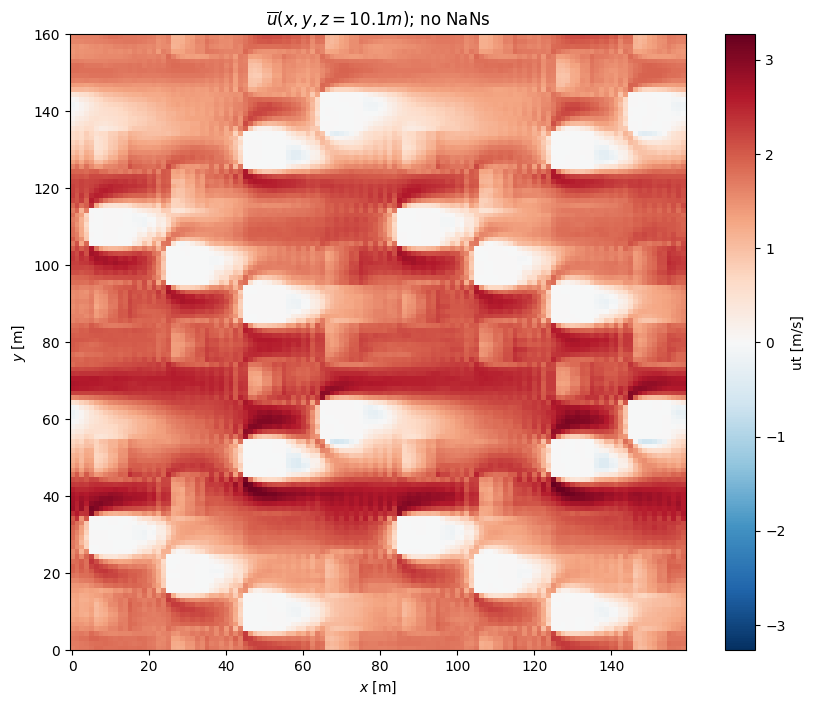

In [10]:
# Find the k-index closest to z=10m
zloc = 10
k = np.argmin(np.abs(zt.values - zloc))

# Choose last time interval
n = -1

fig, ax = plt.subplots(figsize=(10, 8))
ut.isel(time=n, zt=k).plot(ax=ax, cmap='RdBu_r')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_title(f'$\\overline{{u}}(x, y, z={zt.values[k]:.1f}m)$; no NaNs')
plt.show()

You can see that where the buildings are, the velocity is zero. However, since this is a solid domain, you will want to remove these from the plot. You can use the arrays `Su`, `Sv`, `Sw` and `Sc` in the udales object for this, which are 3D boolean matrices that indicate cells that contain buildings as true. There are four different arrays since the grid is staggered. We are dealing with the u-velocity, so will use the array `Su`. In order to do so, we can simply set the cells that contain solid elements to `NaN`:

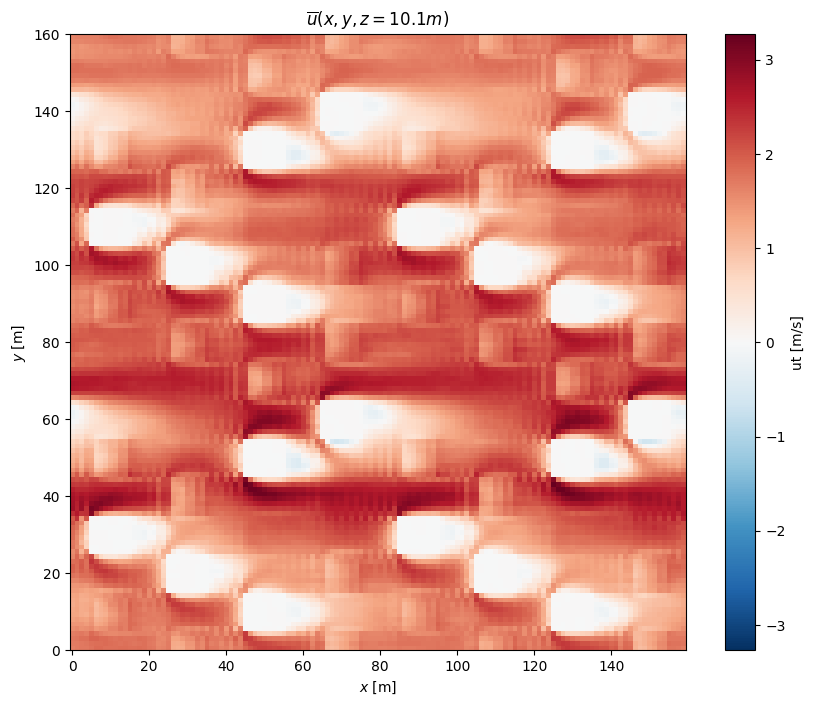

In [11]:
# Mask buildings using Su array
if hasattr(udales, 'Su') and udales.Su is not None:
    curut = ut.isel(time=n).copy()
    # Mask buildings - Su is 3D (x,y,z) so we need to handle properly
    curut_2d = curut.isel(zt=k)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    curut_2d.plot(ax=ax, cmap='RdBu_r')
    ax.set_aspect('equal')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')
    ax.set_title(f'$\\overline{{u}}(x, y, z={zt.values[k]:.1f}m)$')
    plt.show()
else:
    print("Building mask (Su) not available")

Similarly, we can plot a vertical slice in the middle of the y-domain:

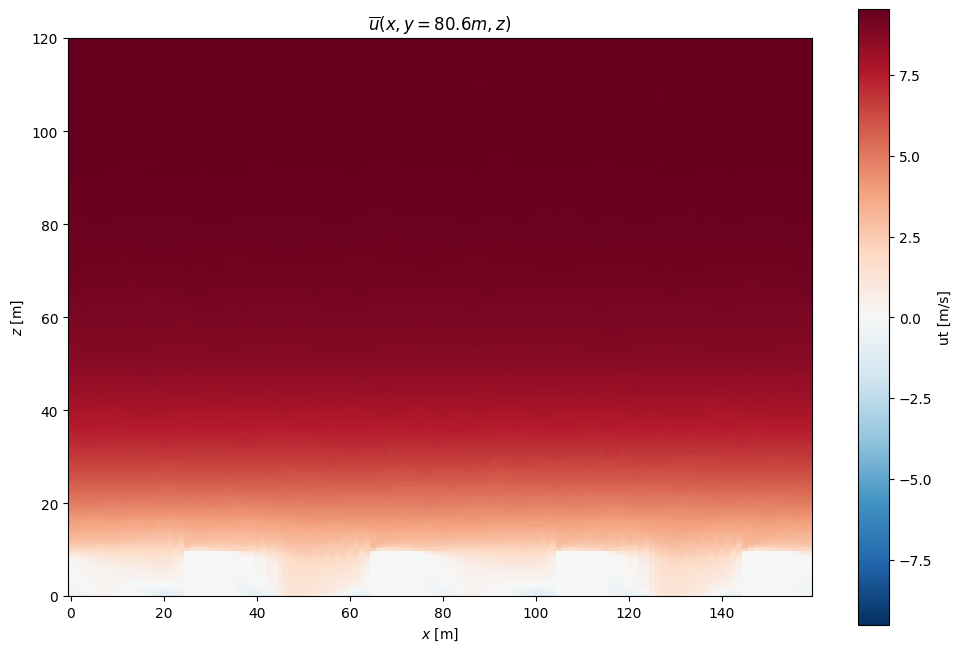

In [12]:
# Select the index in the middle of the domain span
if hasattr(udales, 'jtot'):
    j = udales.jtot // 2
else:
    j = len(yt) // 2

if hasattr(udales, 'Su') and udales.Su is not None:
    fig, ax = plt.subplots(figsize=(12, 8))
    curut.isel(yt=j).plot(ax=ax, cmap='RdBu_r', y='zt')
    ax.set_aspect('equal')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$z$ [m]')
    ax.set_title(f'$\\overline{{u}}(x, y={yt.values[j]:.1f}m, z)$')
    plt.show()
else:
    print("Building mask (Su) not available")

## load_field: loading instantaneous 3D data

The instantaneous field data is stored in the `fielddump.expnr.nc` file. The variable `time` contains the times at which output is written. These times can be understood by noticing the output interval requested in the input file (`tfielddump`).

In [13]:
# Load instantaneous field data
ds_field = udales.load_field()
print(ds_field)

u_field = ds_field['u'] if 'u' in ds_field else None
t_field = ds_field['time']
print(f"Output times: {t_field.values}")


Contents of fielddump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
u                    time, zt, yt, xm               3 x 256 x 128 x 128 
v                    time, zt, ym, xt               3 x 256 x 128 x 128 
w                    time, zm, yt, xt               3 x 256 x 128 x 128 
<xarray.Dataset> Size: 151MB
Dimensions:  (time: 3, zm: 256, yt: 128, xt: 128, zt: 256, ym: 128, xm: 128)
Coordinates:
  * time     (time) float32 12B 2e+03 4e+03 6e+03
  * zm       (zm) float32 1kB 0.0 0.4688 0.9375 1.406 ... 118.6 119.1 119.5
  * yt       (yt) float32 512B 0.625 1.875 3.125 4.375 ... 156.9 158.1 159.4
  * xt       (xt) float32 512B 0.625 1.875 3.125 4.375 ... 156.9 158.1 159.4
  * zt       (zt) float32 1kB 0.2344 0.7031 1.172 1.641 ... 118.8 119.3 119.8
  * ym       (ym) float32 512B 0.0 1.25 2.5 3.75 5.0 ... 155.0 156.2 157.5 158.8
  * xm       (xm) float32 512B 0.0 1.25 2.5 3.75

We plot the instantaneous horizontal velocity at the same locations as in the previous section using the last output time:

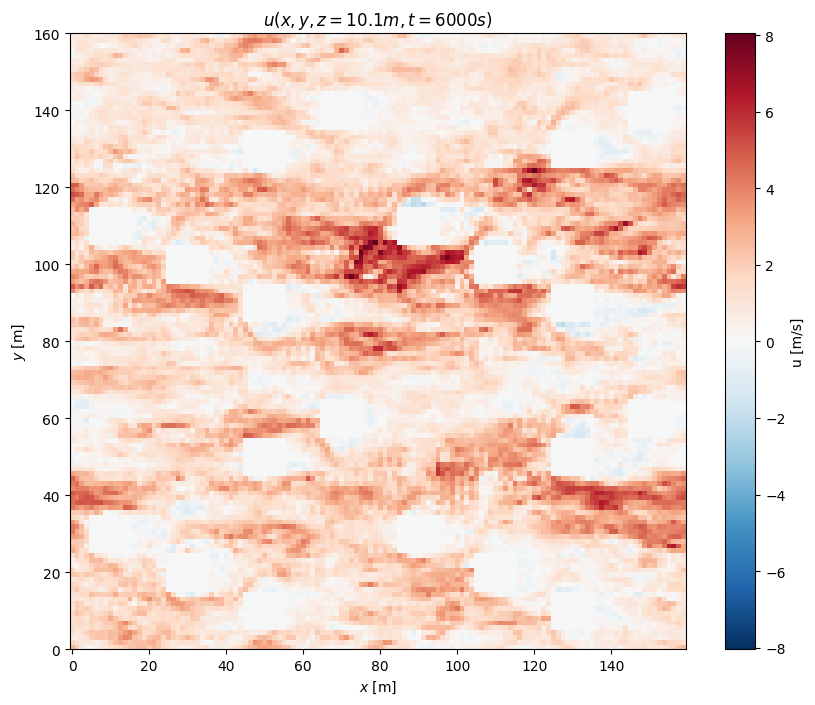

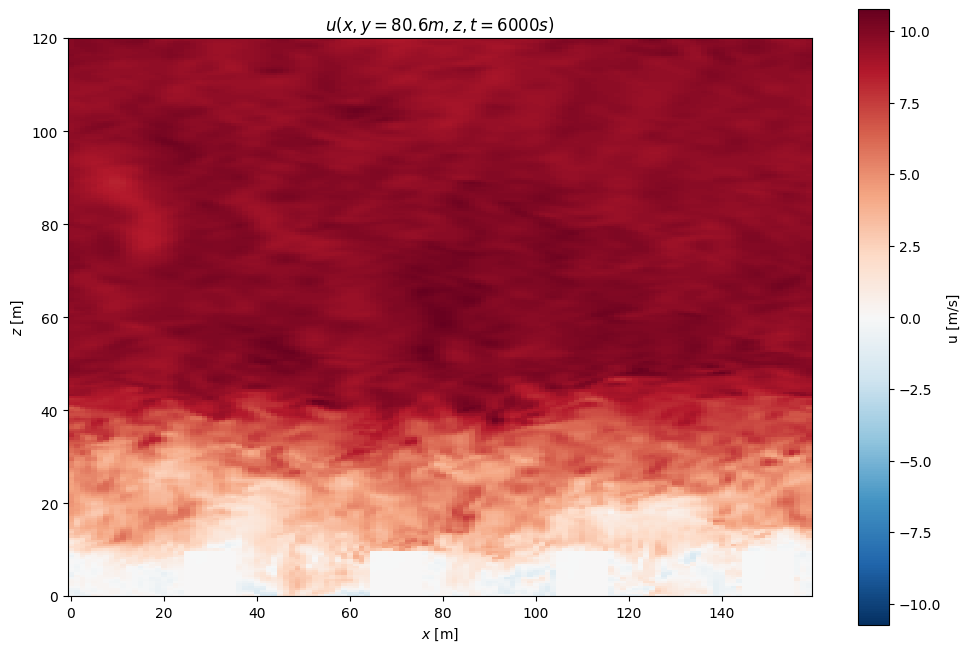

In [14]:
# Plot horizontal slice at z=10m, last time
n = -1
if u_field is not None:
    # Extract 2D slice at the desired height
    u_2d = u_field.isel(time=n, zt=k)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    u_2d.plot(ax=ax, cmap='RdBu_r')
    ax.set_aspect('equal')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')
    ax.set_title(f'$u(x, y, z={zt.values[k]:.1f}m, t={float(t_field.values[n]):.0f}s)$')
    plt.show()
    
    # Plot vertical slice
    u_xz = u_field.isel(time=n, yt=j)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    u_xz.plot(ax=ax, cmap='RdBu_r', y='zt')
    ax.set_aspect('equal')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$z$ [m]')
    ax.set_title(f'$u(x, y={yt.values[j]:.1f}m, z, t={float(t_field.values[n]):.0f}s)$')
    plt.show()
else:
    print("Field data not available")

## load_slice: loading instantaneous 2D slice data

The instantaneous slice data is stored in the `Xslicedump.expnr.nc` file. This file contains particular slices of the 3D instantaneous data, which makes this data particularly suitable for creating animations since the output frequency can be much higher than for 3D fields.

uDALES is capable of outputting slices along the x, y or z-direction. The first argument to the load_slice method is the slice direction:

- `'i'`: vertical slices taken at fixed x. Outputs data that is a function of y, z and t.
- `'j'`: vertical slices taken at fixed y. Outputs data that is a function of x, z and t.
- `'k'`: horizontal slices taken at fixed z. Outputs data that is a function of x, y and t.


Contents of kslicedump.110.nc:
Name                 Dimensions                     Shape               
----------------------------------------------------------------------
qt_kslice            time, yt, xt                   1979 x 128 x 128    
thl_kslice           time, yt, xt                   1979 x 128 x 128    
u_kslice             time, yt, xm                   1979 x 128 x 128    
v_kslice             time, ym, xt                   1979 x 8 x 128      
w_kslice             time, yt, xt                   1979 x 128 x 128    
<xarray.Dataset> Size: 527MB
Dimensions:     (time: 1979, ym: 8, xt: 128, yt: 128, xm: 128)
Coordinates:
  * time        (time) float32 8kB 3.141 6.133 9.193 ... 5.999e+03 6.002e+03
  * xt          (xt) float32 512B 0.625 1.875 3.125 4.375 ... 156.9 158.1 159.4
  * yt          (yt) float32 512B 0.625 1.875 3.125 4.375 ... 156.9 158.1 159.4
  * xm          (xm) float32 512B 0.0 1.25 2.5 3.75 ... 155.0 156.2 157.5 158.8
Dimensions without coordinates: ym
Da

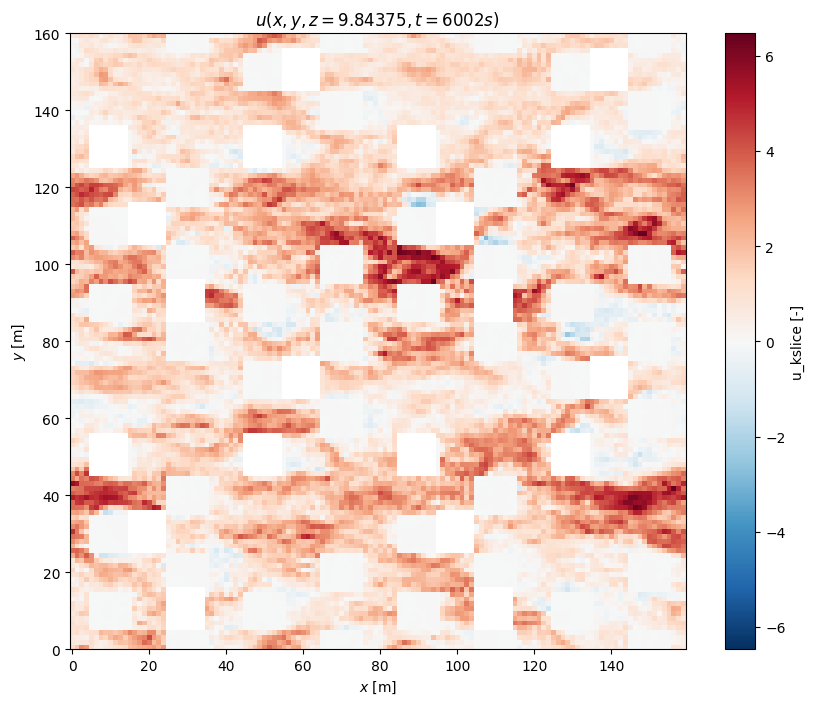

In [15]:
# Load horizontal slice data (k-slices)
try:
    ds_slice = udales.load_slice('k')
    print(ds_slice)
    
    xm_slice = ds_slice['xm'] if 'xm' in ds_slice.coords else ds_slice['x']
    yt_slice = ds_slice['yt'] if 'yt' in ds_slice.coords else ds_slice['y']
    uk = ds_slice['u_kslice'] if 'u_kslice' in ds_slice else (ds_slice['u'] if 'u' in ds_slice else None)
    
    if uk is not None:
        t_slice = ds_slice['time']
        
        # Plot last time step
        n = -1
        if hasattr(udales, 'Su') and hasattr(udales, 'kslice'):
            curu_slice = uk.isel(time=n).copy()
            curu_slice.values[udales.Su[:, :, udales.kslice]] = np.nan
            
            fig, ax = plt.subplots(figsize=(10, 8))
            curu_slice.plot(ax=ax, cmap='RdBu_r')
            ax.set_aspect('equal')
            ax.set_xlabel('$x$ [m]')
            ax.set_ylabel('$y$ [m]')
            zm_val = udales.zm[udales.kslice] if hasattr(udales, 'zm') else 'kslice'
            ax.set_title(f'$u(x, y, z={zm_val}, t={float(t_slice.values[n]):.0f}s)$')
            plt.show()
        else:
            print("Building mask or kslice info not available")
    else:
        print("u_kslice variable not found in slice data")
        
except Exception as e:
    print(f"Could not load slice data: {e}")

## load_stat_tree and plot_trees: loading and plotting tree data

For simulations with trees, uDALES provides methods to load and visualize tree source terms. The time-averaged tree source data is stored in the `treedump.expnr.nc` file.

**Note:** This example requires a simulation with trees enabled (ltrees=.true.). Example 525 from the MATLAB tutorial includes trees.

In [16]:
# Example for tree simulations (requires experiment with trees)
# Uncomment and modify if you have a tree simulation:

# udales_tree = UDBase(expnr=525)
# 
# # Plot tree patches
# udales_tree.plot_trees()
# 
# # List available tree variables
# udales_tree.load_stat_tree()  # Call without arguments to see variables
# 
# # Load tree drag in x-direction
# ds_tree = udales_tree.load_stat_tree(['tr_u', 'tr_thl'])
# tr_u = ds_tree['tr_u']
# 
# # Visualize tree drag at specific height
# fig, ax = plt.subplots(figsize=(12, 10))
# tr_u.isel(time=-1, z=10).plot(ax=ax, cmap='Reds')
# ax.set_aspect('equal')
# ax.set_xlabel('$x$ [m]')
# ax.set_ylabel('$y$ [m]')
# ax.set_title('Tree drag in x-direction')
# plt.show()

print("Tree visualization code available above (commented out).")

Tree visualization code available above (commented out).


## References

[1] Ferziger JH, Peric M (1999) Computational methods for fluid dynamics (3rd ed.). Springer.

[2] Oke TR, Mills G, Christen A, Voogt JA (2017) Urban Climates. Cambridge University Press.

[3] Schmid M, Lawrence GA, Parlange MB, Giometto MG (2019) Volume averaging for urban canopies. Bound-Lay. Met. 173, 349-372.

[4] Suetzl BS, Rooney GG, van Reeuwijk M (2020) Drag Distribution in Idealized Heterogeneous Urban Environments. Bound-Lay. Met. 178, 225-248.